# Investigating MODIS Data
E.g. for latitude/longitude projections, bowtie effect etc.

In [1]:
# EARTHDATA_USERNAME 
# EARTHDATA_PASSWORD 
# environment variables

import os
import scipy
import earthaccess
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

from mpl_toolkits.basemap import Basemap, cm

os.environ['EARTHDATA_USERNAME'] = ''
os.environ['EARTHDATA_PASSWORD'] = ''

/home/anna.jungbluth/anaconda3/envs/iti/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def convert_integers2radiances(ds, 
                               variable= 'EV_250_Aggr1km_RefSB',
                               n=0): # TODO: expand to correct all channels
    
    data = ds[variable][n]
    radiance_scale = ds[variable].radiance_scales
    radiance_offsets = ds[variable].radiance_offsets 
    corrected_data = (data - radiance_offsets[n])*radiance_scale[n]

    return corrected_data
    

In [3]:
def get_central_coords(lat, lon):

    lat_max = lat[0,0]
    lat_min = lat[-1,-1]

    lat_0 = lat_min + (lat_max - lat_min) / 2.

    long_min = min(lon[0,0],lon[-1,-1])
    long_max = max(lon[0,0],lon[-1,-1])

    lon_0 = long_min + (long_max - long_min) / 2.

    return lat_0, lon_0
    

In [4]:
def get_corner_coords(lat_0, lon_0, lat, lon):
    m1 = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution=None)

    xpt0, ypt0 = m1(lon_0,lat_0) # x/y map projection coordinates (in meters)

    xpt1, ypt1 = m1(lon[0,0],lat[0,0]) 
    xpt2, ypt2 = m1(lon[0,-1],lat[0,-1]) 
    xpt3, ypt3 = m1(lon[-1,-1], \
                    lat[-1,-1])
    xpt4, ypt4 = m1(lon[-1,0],lat[-1,0])

    llx = min(xpt1,xpt2,xpt3,xpt4) - xpt0  # lower left
    lly = min(ypt1,ypt2,ypt3,ypt4) - ypt0

    urx = max(xpt1,xpt2,xpt3,xpt4) - xpt0  # upper right
    ury = max(ypt1,ypt2,ypt3,ypt4) - ypt0

    return (llx, lly, urx, ury)

In [5]:
def interp_coords(lat: np.array, lon: np.array, desired_size: tuple=(2030, 1354)) -> np.array:
    # Create grid coordinates for the original and interpolated arrays
    original_rows = np.stack((np.linspace(0, lat.shape[0], num=lat.shape[0]),) * lat.shape[1], axis=1)
    original_cols = np.stack((np.linspace(0, lat.shape[1], num=lat.shape[1]),) * lat.shape[0], axis=0)
    sf_x = desired_size[0]/lat.shape[0]
    sf_y = desired_size[1]/lat.shape[1]
    original_rows = (original_rows) * sf_x
    original_cols = (original_cols) * sf_y
    interp_rows, interp_cols = np.indices(desired_size)

    # Flatten the original array and grid coordinates
    original_positions = np.column_stack((original_rows.flatten(), original_cols.flatten()))
    original_lat = lat.values.flatten()
    original_lon = lon.values.flatten()

    interp_positions = np.column_stack((interp_rows.flatten(), interp_cols.flatten()))

    # Perform 2D interpolation using griddata
    interp_lat = griddata(original_positions, original_lat, interp_positions, method='cubic')
    interp_lon = griddata(original_positions, original_lon, interp_positions, method='cubic')

    # Reshape the interpolated array to the desired size
    interp_lat = interp_lat.reshape(desired_size)
    interp_lon = interp_lon.reshape(desired_size)

    return interp_lat, interp_lon

### Download Level-1B data

In [30]:
# try: short_name='MOD02HKM'
# count: if set to a n, search_data returns the first n results - if n is greater than the number of results, all results are returned

results = earthaccess.search_data(
    short_name='MOD021KM',
    cloud_hosted=True,
    # bounding_box=(-50, 50, 50, 50),
    temporal=("2018-10-01 09:00", "2018-10-01 11:00"),
    count=-1
)

Granules found: 26


In [31]:
results

[Collection: {'ShortName': 'MOD021KM', 'Version': '6.1'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 15.463196, 'Latitude': 34.690848}, {'Longitude': 40.561509, 'Latitude': 31.304041}, {'Longitude': 49.784007, 'Latitude': 48.343844}, {'Longitude': 16.761684, 'Latitude': 53.073111}, {'Longitude': 15.463196, 'Latitude': 34.690848}]}}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2018-10-01T08:55:00.000Z', 'EndingDateTime': '2018-10-01T09:00:00.000Z'}}
 Size(MB): 162.280035972595
 Data: ['https://ladsweb.modaps.eosdis.nasa.gov/archive/allData/61/MOD021KM/2018/274/MOD021KM.A2018274.0855.061.2018274200306.hdf'],
 Collection: {'ShortName': 'MOD021KM', 'Version': '6.1'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'GPolygons': [{'Boundary': {'Points': [{'Longitude': 12.842718, 'Latitude': 16.868411}, {'Longitude': 34.492933, 'Latitude': 13.879841}, {'Longitude': 40.163424, 'Latitude': 31.4

In [32]:
files = earthaccess.download(results, "./modisdata/earthaccess2/")

 Getting 26 granules, approx download size: 3.09 GB


QUEUEING TASKS | : 100%|██████████| 26/26 [00:00<00:00, 1972.26it/s]


File MOD021KM.A2018274.0855.061.2018274200306.hdf already downloaded


PROCESSING TASKS | :  46%|████▌     | 12/26 [00:13<00:12,  1.16it/s]

File MOD021KM.A2018274.1030.061.2018274200208.hdf already downloaded
File MOD021KM.A2018274.1035.061.2018274200111.hdf already downloaded
File MOD021KM.A2018274.1040.061.2018274200246.hdf already downloaded


PROCESSING TASKS | : 100%|██████████| 26/26 [00:37<00:00,  1.44s/it]
COLLECTING RESULTS | : 100%|██████████| 26/26 [00:00<00:00, 136314.88it/s]


In [64]:
ds = xr.open_dataset('./modisdata/earthaccess2/MOD021KM.A2018274.1035.061.2018274200111.hdf', engine='netcdf4')
ds

<xarray.Dataset>
Dimensions:                                            (
                                                        2*nscans:MODIS_SWATH_Type_L1B: 406,
                                                        1KM_geo_dim:MODIS_SWATH_Type_L1B: 271,
                                                        Band_1KM_RefSB:MODIS_SWATH_Type_L1B: 15,
                                                        10*nscans:MODIS_SWATH_Type_L1B: 2030,
                                                        Max_EV_frames:MODIS_SWATH_Type_L1B: 1354,
                                                        ...
                                                        number of scans: 203,
                                                        number of 250m bands: 2,
                                                        detectors per 250m band: 40,
                                                        number of 500m bands: 5,
                                                        detectors per 500m band: 20,
                                                        number of 1km reflective bands: 15)
Coordinates:
  * Band_250M                                          (Band_250M) float32 1....
  * Band_500M                                          (Band_500M) float32 3....
  * Band_1KM_RefSB                                     (Band_1KM_RefSB) float32 ...
  * Band_1KM_Emissive                                  (Band_1KM_Emissive) float32 ...
Dimensions without coordinates: 2*nscans:MODIS_SWATH_Type_L1B,
                                1KM_geo_dim:MODIS_SWATH_Type_L1B,
                                Band_1KM_RefSB:MODIS_SWATH_Type_L1B,
                                10*nscans:MODIS_SWATH_Type_L1B,
                                Max_EV_frames:MODIS_SWATH_Type_L1B,
                                Band_1KM_Emissive:MODIS_SWATH_Type_L1B,
                                ...
                                Band_500M:MODIS_SWATH_Type_L1B,
                                number of emissive bands,
                                detectors per 1km band, number of scans,
                                number of 250m bands, detectors per 250m band,
                                number of 500m bands, detectors per 500m band,
                                number of 1km reflective bands
Data variables: (12/27)
    Latitude                                           (2*nscans:MODIS_SWATH_Type_L1B, 1KM_geo_dim:MODIS_SWATH_Type_L1B) float32 ...
    Longitude                                          (2*nscans:MODIS_SWATH_Type_L1B, 1KM_geo_dim:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_RefSB                                       (Band_1KM_RefSB:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_RefSB_Uncert_Indexes                        (Band_1KM_RefSB:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_Emissive                                    (Band_1KM_Emissive:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_Emissive_Uncert_Indexes                     (Band_1KM_Emissive:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    ...                                                 ...
    Noise in Thermal Detectors                         (number of emissive bands, detectors per 1km band) uint8 ...
    Change in relative responses of thermal detectors  (number of emissive bands, detectors per 1km band) uint8 ...
    DC Restore Change for Thermal Bands                (number of scans, number of emissive bands, detectors per 1km band) int8 ...
    DC Restore Change for Reflective 250m Bands        (number of scans, number of 250m bands, detectors per 250m band) int8 ...
    DC Restore Change for Reflective 500m Bands        (number of scans, number of 500m bands, detectors per 500m band) int8 ...
    DC Restore Cha

### Plotting data without coordinate projections

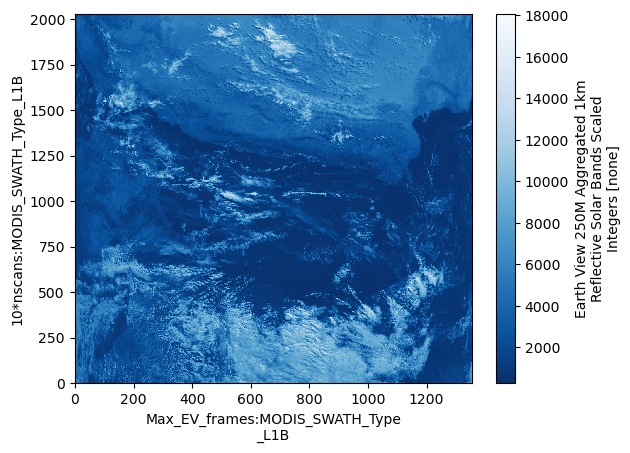

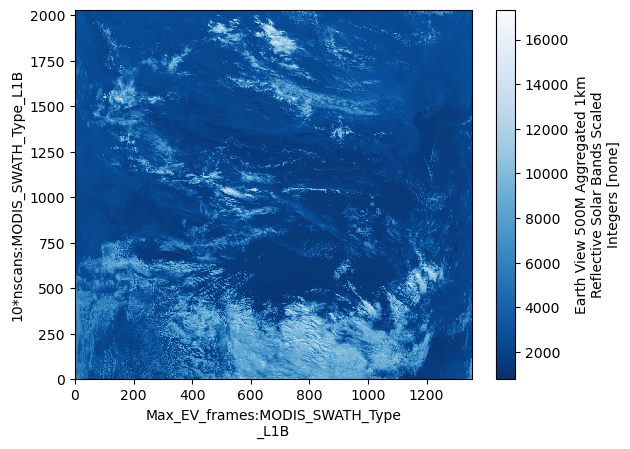

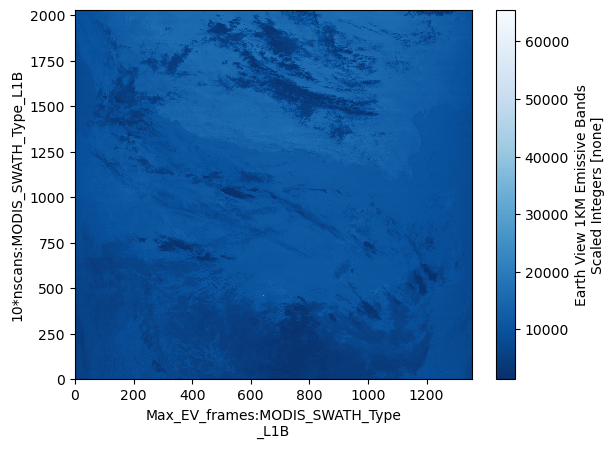

In [290]:
plt.figure()
ds.EV_250_Aggr1km_RefSB[0].plot(cmap='Blues_r') # band 1
plt.figure()
ds.EV_500_Aggr1km_RefSB[0].plot(cmap='Blues_r') # band 3
plt.figure()
ds.EV_1KM_Emissive[5].plot(cmap='Blues_r') # band 25

In [68]:
ds

<xarray.Dataset>
Dimensions:                                            (
                                                        2*nscans:MODIS_SWATH_Type_L1B: 406,
                                                        1KM_geo_dim:MODIS_SWATH_Type_L1B: 271,
                                                        Band_1KM_RefSB:MODIS_SWATH_Type_L1B: 15,
                                                        10*nscans:MODIS_SWATH_Type_L1B: 2030,
                                                        Max_EV_frames:MODIS_SWATH_Type_L1B: 1354,
                                                        ...
                                                        number of scans: 203,
                                                        number of 250m bands: 2,
                                                        detectors per 250m band: 40,
                                                        number of 500m bands: 5,
                                                        detectors per 500m band: 20,
                                                        number of 1km reflective bands: 15)
Coordinates:
  * Band_250M                                          (Band_250M) float32 1....
  * Band_500M                                          (Band_500M) float32 3....
  * Band_1KM_RefSB                                     (Band_1KM_RefSB) float32 ...
  * Band_1KM_Emissive                                  (Band_1KM_Emissive) float32 ...
Dimensions without coordinates: 2*nscans:MODIS_SWATH_Type_L1B,
                                1KM_geo_dim:MODIS_SWATH_Type_L1B,
                                Band_1KM_RefSB:MODIS_SWATH_Type_L1B,
                                10*nscans:MODIS_SWATH_Type_L1B,
                                Max_EV_frames:MODIS_SWATH_Type_L1B,
                                Band_1KM_Emissive:MODIS_SWATH_Type_L1B,
                                ...
                                Band_500M:MODIS_SWATH_Type_L1B,
                                number of emissive bands,
                                detectors per 1km band, number of scans,
                                number of 250m bands, detectors per 250m band,
                                number of 500m bands, detectors per 500m band,
                                number of 1km reflective bands
Data variables: (12/27)
    Latitude                                           (2*nscans:MODIS_SWATH_Type_L1B, 1KM_geo_dim:MODIS_SWATH_Type_L1B) float32 ...
    Longitude                                          (2*nscans:MODIS_SWATH_Type_L1B, 1KM_geo_dim:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_RefSB                                       (Band_1KM_RefSB:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_RefSB_Uncert_Indexes                        (Band_1KM_RefSB:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_Emissive                                    (Band_1KM_Emissive:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    EV_1KM_Emissive_Uncert_Indexes                     (Band_1KM_Emissive:MODIS_SWATH_Type_L1B, 10*nscans:MODIS_SWATH_Type_L1B, Max_EV_frames:MODIS_SWATH_Type_L1B) float32 ...
    ...                                                 ...
    Noise in Thermal Detectors                         (number of emissive bands, detectors per 1km band) uint8 ...
    Change in relative responses of thermal detectors  (number of emissive bands, detectors per 1km band) uint8 ...
    DC Restore Change for Thermal Bands                (number of scans, number of emissive bands, detectors per 1km band) int8 ...
    DC Restore Change for Reflective 250m Bands        (number of scans, number of 250m bands, detectors per 250m band) int8 ...
    DC Restore Change for Reflective 500m Bands        (number of scans, number of 500m bands, detectors per 500m band) int8 ...
    DC Restore Cha

### Converting Scaled Integers to Radiances

In [83]:
ds.EV_250_Aggr1km_RefSB # The values provided are unitless

<xarray.DataArray 'EV_250_Aggr1km_RefSB' (Band_250M:MODIS_SWATH_Type_L1B: 2,
                                          10*nscans:MODIS_SWATH_Type_L1B: 2030,
                                          Max_EV_frames:MODIS_SWATH_Type_L1B: 1354)>
[5497240 values with dtype=float32]
Dimensions without coordinates: Band_250M:MODIS_SWATH_Type_L1B,
                                10*nscans:MODIS_SWATH_Type_L1B,
                                Max_EV_frames:MODIS_SWATH_Type_L1B
Attributes: (12/13)
    long_name:                 Earth View 250M Aggregated 1km Reflective Sola...
    units:                     none
    valid_range:               [    0 32767]
    band_names:                1,2
    radiance_scales:           [0.02907378 0.01079062]
    radiance_offsets:          [-0. -0.]
    ...                        ...
    reflectance_scales:        [5.700265e-05 3.424760e-05]
    reflectance_offsets:       [-0. -0.]
    reflectance_units:         none
    corrected_counts_scales:   [0.1249733 0.1249733]
    corrected_counts_offsets:  [-0. -0.]
    corrected_counts_units:    counts

In [84]:
radiance_scale = ds.EV_250_Aggr1km_RefSB.radiance_scales
radiance_offsets = ds.EV_250_Aggr1km_RefSB.radiance_offsets

In [102]:
data = ds.EV_250_Aggr1km_RefSB[0]
print('Max value: ', max(data.values.flatten()))
print('Min value: ', min(data.values.flatten()))

Max value:  18076.0
Min value:  269.0


In [103]:
corrected_data = (data - radiance_offsets[0])*radiance_scale[0]
print('Max value: ', max(corrected_data.values.flatten()))
print('Min value: ', min(corrected_data.values.flatten()))

Max value:  525.5377
Min value:  7.820848


NOTE: The shape of the data does not match the shape of the geolocation information!!!

In [98]:
print('Shape of Lat/Lon coords: ', ds.Latitude.shape)
print('Shape of data: ', ds.EV_250_Aggr1km_RefSB[0].shape)

Shape of Lat/Lon coords:  (406, 271)
Shape of data:  (2030, 1354)


### Plotting data in orthographic projection

In [292]:
lat = ds.Latitude
lon = ds.Longitude

along_track = corrected_data.shape[0]
cross_trak = corrected_data.shape[1]

In [293]:
# Rough estimation of latitude and longitude at granule center (long_0, lat_0)

lat_max = lat[0,0]
lat_min = lat[-1,-1]

lat_0 = lat_min + (lat_max - lat_min) / 2.

long_min = min(lon[0,0],lon[-1,-1])
long_max = max(lon[0,0],lon[-1,-1])

lon_0 = long_min + (long_max - long_min) / 2.

In [294]:
# Determine corner coordinates in meters

m1 = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution=None)

xpt0, ypt0 = m1(lon_0,lat_0) # x/y map projection coordinates (in meters)

xpt1, ypt1 = m1(lon[0,0],lat[0,0]) 
xpt2, ypt2 = m1(lon[0,-1],lat[0,-1]) 
xpt3, ypt3 = m1(lon[-1,-1], \
                lat[-1,-1])
xpt4, ypt4 = m1(lon[-1,0],lat[-1,0])

llx = min(xpt1,xpt2,xpt3,xpt4) - xpt0  # lower left
lly = min(ypt1,ypt2,ypt3,ypt4) - ypt0

urx = max(xpt1,xpt2,xpt3,xpt4) - xpt0  # upper right
ury = max(ypt1,ypt2,ypt3,ypt4) - ypt0

/tmp/ipykernel_1598/152707701.py:12: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data[::5, ::5], shading='auto', cmap='Blues_r')


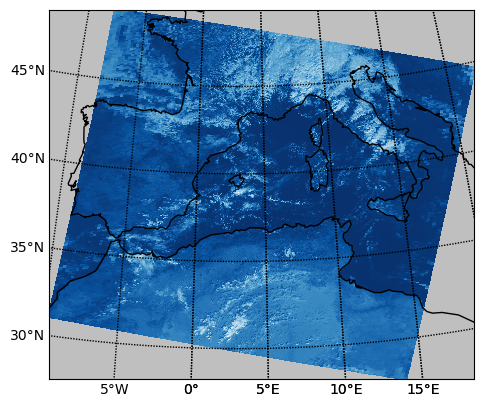

In [295]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.patch.set_facecolor((0.75,0.75,0.75))

m = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution='l',\
    llcrnrx=llx,llcrnry=lly,urcrnrx=urx,urcrnry=ury) # needed to zoom into area of interest

lons, lats = m(lon, lat)

m.pcolormesh(lons, lats, corrected_data[::5, ::5], shading='auto', cmap='Blues_r')

m.drawcoastlines()

m.drawparallels(np.arange(-90.,90.,5.), color='k', labels=[True,False,False,False])
m.drawmeridians(np.arange(0.,420.,5.), color='k', labels=[False,False,False,True])

plt.show()

### Interpolating & plotting data in orthographic projection

/tmp/ipykernel_1598/1571275645.py:16: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


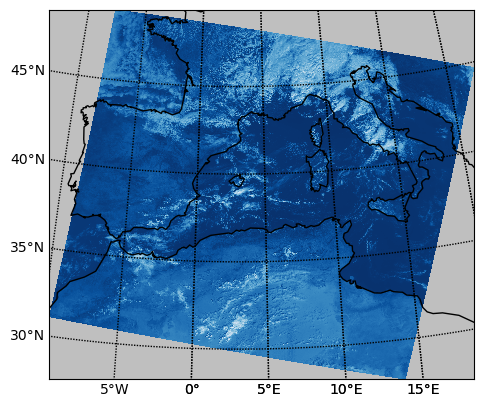

In [297]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.patch.set_facecolor((0.75,0.75,0.75))

interp_lat, interp_lon = interp_coords(lat, lon)
lat_0, lon_0 = get_central_coords(interp_lat, interp_lon)
llx, lly, urx, ury = get_corner_coords(lat_0, lon_0, interp_lat, interp_lon)

m = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution='l',\
    llcrnrx=llx,llcrnry=lly,urcrnrx=urx,urcrnry=ury) # needed to zoom into area of interest

lons, lats = m(interp_lon, interp_lat)

m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')

m.drawcoastlines()

m.drawparallels(np.arange(-90.,90.,5.), color='k', labels=[True,False,False,False])
m.drawmeridians(np.arange(0.,420.,5.), color='k', labels=[False,False,False,True])

plt.show()

### Plotting multiple swaths

/tmp/ipykernel_3725/3916717808.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')
/tmp/ipykernel_3725/3916717808.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')
/tmp/ipykernel_3725/3916717808.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges t

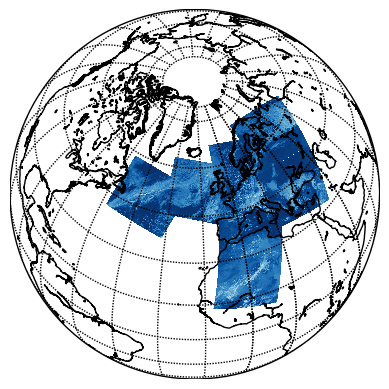

In [26]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.patch.set_facecolor((0.75,0.75,0.75))

setup_plot = True

for file in os.listdir('./modisdata/earthaccess2/'):
    if file.startswith('MOD02'):
        ds = xr.open_dataset('./modisdata/earthaccess2/'+file, engine='netcdf4')
        corrected_data = convert_integers2radiances(ds)
        lat = ds.Latitude
        lon = ds.Longitude
        interp_lat, interp_lon = interp_coords(lat, lon, desired_size=corrected_data.shape)
        lat_0, lon_0 = get_central_coords(interp_lat, interp_lon)
        llx, lly, urx, ury = get_corner_coords(lat_0, lon_0, interp_lat, interp_lon)

        if setup_plot:
            m = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution='l')
            setup_plot = False

        lons, lats = m(interp_lon, interp_lat) 
        m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')

m.drawcoastlines()
m.drawparallels(np.arange(-90.,90.,15.), color='k', labels=[True,False,False,False])
m.drawmeridians(np.arange(0.,420.,15.), color='k', labels=[False,False,False,True])

plt.show()
        

Note: some swaths did not successfully plot, with error "Unlabeled multi-dimensional array cannot be used for indexing"

In [46]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.patch.set_facecolor((0.75,0.75,0.75))

setup_plot = True

for file in os.listdir('./modisdata/earthaccess2/'):
    if file.startswith('MOD02'):
        print(file)
        ds = xr.open_dataset('./modisdata/earthaccess2/'+file, engine='netcdf4')
        corrected_data = convert_integers2radiances(ds)
        lat = ds.Latitude
        lon = ds.Longitude
        interp_lat, interp_lon = interp_coords(lat, lon, desired_size=corrected_data.shape)
        lat_0, lon_0 = get_central_coords(interp_lat, interp_lon)
        llx, lly, urx, ury = get_corner_coords(lat_0, lon_0, interp_lat, interp_lon)

        if setup_plot:
            m = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution='l')
            m.drawcoastlines()
            m.drawparallels(np.arange(-90.,90.,15.), color='k', labels=[True,False,False,False])
            m.drawmeridians(np.arange(0.,420.,15.), color='k', labels=[False,False,False,True])
            setup_plot = False

        lons, lats = m(interp_lon, interp_lat) 
        if np.count_nonzero(~np.isnan(corrected_data)) != 0:
            m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')

plt.show()
        

MOD021KM.A2018274.1045.061.2018274200314.hdf

/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0950.061.2018274200119.hdf
MOD021KM.A2018274.1055.061.2018274200200.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1210.061.2018275090314.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1050.061.2018274200243.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1010.061.2018274200049.hdf
MOD021KM.A2018274.0935.061.2018274200229.hdf
MOD021KM.A2018274.0955.061.2018274200118.hdf
MOD021KM.A2018274.1000.061.2018274200047.hdf
MOD021KM.A2018274.1030.061.2018274200208.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0915.061.2018274200246.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1025.061.2018274200237.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0925.061.2018274200247.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0850.061.2018274200236.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0905.061.2018274200236.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1035.061.2018274200111.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0855.061.2018274200306.hdf


/tmp/ipykernel_3725/2125488239.py:28: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0930.061.2018274200220.hdf


IndexError: Unlabeled multi-dimensional array cannot be used for indexing: 10*nscans:MODIS_SWATH_Type_L1B

: 

/tmp/ipykernel_3725/3908350071.py:20: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


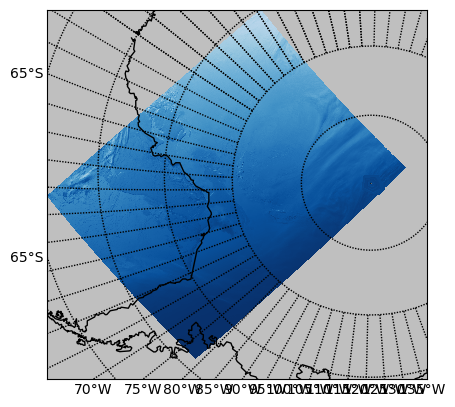

In [43]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.patch.set_facecolor((0.75,0.75,0.75))

ds = xr.open_dataset('./modisdata/earthaccess2/MOD021KM.A2018274.0930.061.2018274200220.hdf', engine='netcdf4')
corrected_data = convert_integers2radiances(ds)
lat = ds.Latitude
lon = ds.Longitude
interp_lat, interp_lon = interp_coords(lat, lon, desired_size=corrected_data.shape)
lat_0, lon_0 = get_central_coords(interp_lat, interp_lon)
llx, lly, urx, ury = get_corner_coords(lat_0, lon_0, interp_lat, interp_lon)

m = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution='l',\
    llcrnrx=llx,llcrnry=lly,urcrnrx=urx,urcrnry=ury) # needed to zoom into area of interest

lons, lats = m(interp_lon, interp_lat)

m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')

m.drawcoastlines()

m.drawparallels(np.arange(-90.,90.,5.), color='k', labels=[True,False,False,False])
m.drawmeridians(np.arange(0.,420.,5.), color='k', labels=[False,False,False,True])

plt.show()

In [45]:
np.count_nonzero(np.isnan(corrected_data))

338500

MOD021KM.A2018274.1045.061.2018274200314.hdf

/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0950.061.2018274200119.hdf
MOD021KM.A2018274.1055.061.2018274200200.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1210.061.2018275090314.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1050.061.2018274200243.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1010.061.2018274200049.hdf
MOD021KM.A2018274.0935.061.2018274200229.hdf
MOD021KM.A2018274.0955.061.2018274200118.hdf
MOD021KM.A2018274.1000.061.2018274200047.hdf
MOD021KM.A2018274.1030.061.2018274200208.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0915.061.2018274200246.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1025.061.2018274200237.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0925.061.2018274200247.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0850.061.2018274200236.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0905.061.2018274200236.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1035.061.2018274200111.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0855.061.2018274200306.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0930.061.2018274200220.hdf
MOD021KM.A2018274.0910.061.2018274200238.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1100.061.2018274200249.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0920.061.2018274200213.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0940.061.2018274200223.hdf
MOD021KM.A2018274.1040.061.2018274200246.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1015.061.2018274200054.hdf
MOD021KM.A2018274.1005.061.2018274200100.hdf
MOD021KM.A2018274.1350.061.2018275090443.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.1020.061.2018274200148.hdf
MOD021KM.A2018274.0900.061.2018274200126.hdf


/tmp/ipykernel_4407/956176237.py:29: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')


MOD021KM.A2018274.0945.061.2018274200228.hdf


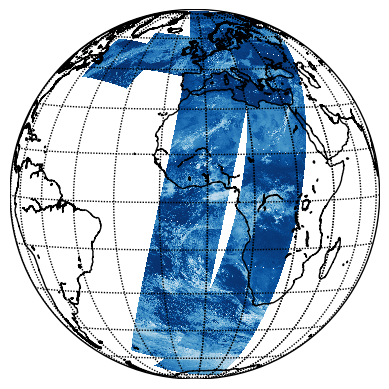

In [6]:
fig = plt.figure()

ax = fig.add_subplot(111)
ax.patch.set_facecolor((0.75,0.75,0.75))

setup_plot = True

for file in os.listdir('./modisdata/earthaccess2/'):
    if file.startswith('MOD02'):
        print(file)
        ds = xr.open_dataset('./modisdata/earthaccess2/'+file, engine='netcdf4')
        corrected_data = convert_integers2radiances(ds)
        lat = ds.Latitude
        lon = ds.Longitude
        interp_lat, interp_lon = interp_coords(lat, lon, desired_size=corrected_data.shape)
        lat_0, lon_0 = get_central_coords(interp_lat, interp_lon)
        llx, lly, urx, ury = get_corner_coords(lat_0, lon_0, interp_lat, interp_lon)

        if setup_plot:
            m = Basemap(projection='ortho',lon_0=lon_0,lat_0=lat_0,resolution='l')
            m.drawcoastlines()
            m.drawparallels(np.arange(-90.,90.,15.), color='k', labels=[True,False,False,False])
            m.drawmeridians(np.arange(0.,420.,15.), color='k', labels=[False,False,False,True])
            setup_plot = False

        lons, lats = m(interp_lon, interp_lat) 
        if np.count_nonzero(~np.isnan(corrected_data)) != 0:
            try:
                m.pcolormesh(lons, lats, corrected_data, shading='auto', cmap='Blues_r')
            except IndexError:
                pass

plt.show()
        